In [6]:
#libraries needed

from google.colab import files

# !pip install emoji
# !pip install langdetect
# !pip install snscrape
# !pip install emot
# !pip install num2words
# !pip install contractions
# !pip install transformers


import pytz

import re
import pandas as pd
import emoji
#-----

import datetime
import time
from datetime import date, timedelta

#---------


import snscrape.modules.twitter as sntwitter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.util import ngrams

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')

from num2words import num2words
import contractions

import string

from wordcloud import WordCloud, STOPWORDS
from emot.emo_unicode import UNICODE_EMOJI

%matplotlib inline

from gensim.models import Word2Vec

import io
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.keyedvectors import KeyedVectors
import torch
from sklearn.decomposition import TruncatedSVD
import plotly.express as px
from sklearn.manifold import TSNE, LocallyLinearEmbedding
import gensim
import gensim.downloader as model_api
from gensim.models import KeyedVectors
from sklearn.base import BaseEstimator, TransformerMixin, ClusterMixin
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import Model, metrics
import tensorflow as tf
from tensorflow import keras
from scipy.sparse import csr_matrix
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import adjusted_rand_score
from collections import Counter
from gensim import corpora
from gensim.models import LdaModel
from sklearn.cluster import Birch
from gensim import corpora
from gensim.models import LdaModel
from sklearn.mixture import GaussianMixture
from transformers import AutoTokenizer, AutoModel
import warnings
warnings.filterwarnings('ignore')
word_vectors = model_api.load("glove-wiki-gigaword-50")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
start_date_list = [date(2021, 1, 6),# February 6, 2021: Queen
date(2022, 2, 24), #  February 24 2022 : russia invades Ukraine
date(2022, 9, 16), # September 16 2022 : Protest in Iran against Hijab
date(2022, 10, 22),# November 25 2022 : Black friday
date(2022, 10, 28),# Oct 28 2022: Elon takes over Twitter 
date(2022, 11, 9), # November 9 2022 : META 11,000 jobs  layoff
date(2022, 11, 15),# November 15 2022 : wolrd population> 8Billions 
date(2022, 11, 25),# October 25 2022: UK gets its first Indian-origin PM 
date(2022, 11, 30),# November 30 2022 : Release of ChatGPT 3
date(2023, 1, 18), # January 18 2023 : Microsoft 10000 lay offs
date(2023, 1, 23), # January 1, 2023: Brazil shifts to the left
date(2023, 2, 12)  # Feb. 12 2023 : Rihanna Performs At The Super Bowl Halftime Show 
]
date_list_since = []
date_list_until = []

# difference between current and previous date
delta = timedelta(days=1)

for date in start_date_list:
    # add current date to list by converting  it to iso format
    date_list_since.append(date.isoformat())
    # increment start date by timedelta
    until_date = date + delta
    date_list_until.append(until_date.isoformat())



In [ ]:
# no_keyword_tweets = []
# count = 0
# for i in range(len(date_list_until)):
#     print(count)
#     count+=1
#     query = str('lang:en since:'+date_list_since[i]+' until:'+date_list_until[i])
#     for i, tweet in enumerate(sntwitter.TwitterSearchScraper(query).get_items()):
#         if i > 1700:
#             break
#         no_keyword_tweets.append([getattr(tweet, attr) for attr in dir(tweet) if not attr.startswith('__')])

# df_no_keyword = pd.DataFrame(no_keyword_tweets, columns=[attr for attr in dir(tweet) if not attr.startswith('__')])

In [7]:
# path_ukrain = "/content/drive/MyDrive/DataScienceCONCORDIA/PROJECT_CSV/40000_ukraine.csv"
path_worldEventsDays = "/content/20000_no_keyword.csv"

#df = pd.read_csv(path_ukrain) 

df = pd.read_csv(path_worldEventsDays) 
#df = pd.read_csv(io.BytesIO(uploaded['20000_no_keyword.csv']))

#print(df)

In [9]:
#Function that cleans dataset  
def pre_process(text):

    # Remove mentions
    mention_pattern = r'@\w+'
    text = re.sub(mention_pattern, '', text)  

    #text in lower case
    text = str(text).lower()

    #remove emojis
    text = emoji.demojize(text)
    text = re.sub(r':\w+', '', text)

    #remove mords starting with '@'
    text = re.sub(r'@\w+', '', text)

    #remove points
    text = text.replace('.', '') 

    #remove 2 points
    text = text.replace(':', '')

    #remove urls
    text = re.sub('http\S+|www.\S+', '', text)
    
    #convert currency signs to words
    currency_dict = {
    '$': 'dollars',
    '£': 'pounds',
    '€': 'euros',
    '¥': 'yen',
    '₹': 'rupees',
    }
    for symbol, word in currency_dict.items():
        text = text.replace(symbol, word)

    #convert numbers into words
    matches = re.findall(r'\d+', text)
    for match in matches:
        word = num2words(int(match))
        text = text.replace(match, word)

    #use the contractions to expand contractions (ex. doesn't to does not)
    text = contractions.fix(text)

    #remove punctuation
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
   

    #remove multiple spaces
    text = re.sub(' +', ' ', text)

    #remove <> and content inside
    text = re.sub('<.*?>+', '', text)

    #remove any ASCII character thats left like ¿
    text = text.replace("¿", '')
    text = re.sub(r'[\'"‘’“”]', '', text)

    return text

In [10]:
#Applying clean function to content of every Tweet
df['content'] = df['content'].apply(pre_process)

In [11]:
df['content']

0         such a sweetie hope she is sleeping alright f...
1         hiya nagito just finished throwing mius body ...
2        for these songs i am posting the only stuff no...
3         i get it i think her experience will be helpf...
4         oh and yeah you lost georgia again welcome wa...
                               ...                        
20407                                              no john
20408     there is only one little gf hoshi vid which a...
20409              you just answered my question thank you
20410          kansas city is mawchin down da field ughkay
20411     buttigiegs diversity inclusion and equity in ...
Name: content, Length: 20412, dtype: object

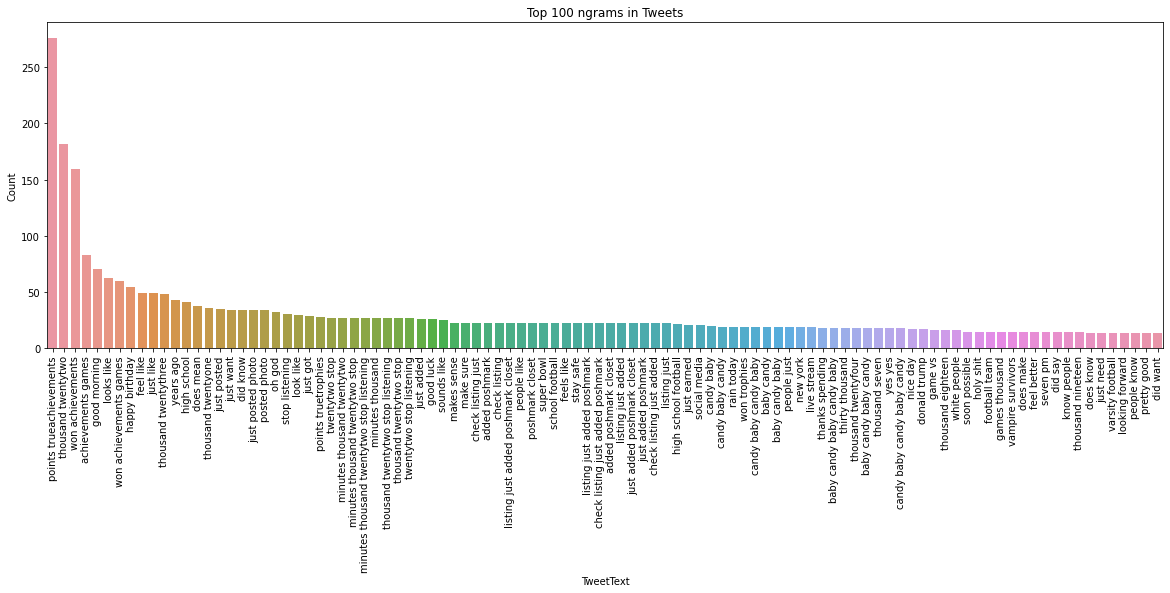

In [12]:
# TOP NGRAMS(Group of words that are repeated 2-5 words each) IN TWEETS FOR THE WHOLE DATASET
def get_top_n_bigram(corpus, n=None):
    
    vec = CountVectorizer(ngram_range=(2, 5), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(df['content'], 100)

df1 = pd.DataFrame(common_words, columns=['TweetText', 'count'])
sorted_counts = df1.groupby('TweetText').sum()['count'].sort_values(ascending=False)

#PLOT N_GRAMS IN A BAR PLOT
plt.figure(figsize=(20, 6))
sns.barplot(x=sorted_counts.index[:100], y=sorted_counts.values[:100])
plt.title('Top 100 ngrams in Tweets')
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.show()

In [ ]:
#We rtied multiple combinations of the following: vectorisers, dimentionality techniques and clustering methods. (The method below produced the best results)

In [13]:
# BERT MODEL seemed to produce the best results - also tried (TFID, Count, Word2Vec, Doc2Vec, GloVe)
#TOKENIZATION OF EACH TWEET
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
#FIT IN A PRE-TRAINED MODEL
model = AutoModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [14]:
# Get embeddings for tokenized data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model.to(device)

#Create enmbedding list
embeddings = []
for text in df['content']:
    tokenized_data = tokenizer(text, truncation=True, padding=True, return_tensors="pt")
    batch_input = {k: v.to(device) for k, v in tokenized_data.items()}
    with torch.no_grad():
        output = model(**batch_input)
    embedding = output.last_hidden_state.mean(dim=1)
    embeddings.append(embedding.cpu())

Device: cuda:0


In [15]:
#Concatenate all the tensors in the embeddings list
embeddings = torch.cat(embeddings).numpy()

In [16]:
# BOTH OPTIONS (SVD/TSNE ARE GOOD but SVD scores better - also tried TSNE, UMAP, PCA and Autoencoders (2) *probably best but didn't have time to play with params)

svd = TruncatedSVD(n_components=3)

embeddings_svd = svd.fit_transform(embeddings)

#tsne = TSNE(n_components=3)

#embeddings_tsne = tsne.fit_transform(embeddings)

In [17]:
# Gaussian gave the best results in term of clustering - also tried (BIRCH, DBSCAN, HDBSCAN, Hierarchical (2), Agglomerative, Spectral, Kmeans, OPTICAL)

n_clusters = 6

gmm = GaussianMixture(n_components=n_clusters)
gmm.fit(embeddings_svd)

labels = gmm.predict(embeddings_svd)

fig = px.scatter(x=embeddings_svd[:, 0], y=embeddings_svd[:, 1], color=labels)
fig.update_layout(
    plot_bgcolor='rgb(0,0,0)'
)

fig.show()

print("Silhouette score:", silhouette_score(embeddings_svd, labels))
print("Calinski-Harabasz score:", calinski_harabasz_score(embeddings_svd, labels))
print("Davies-Bouldin score:", davies_bouldin_score(embeddings_svd, labels))

Silhouette score: 0.31001925
Calinski-Harabasz score: 15658.183863701403
Davies-Bouldin score: 0.9606252895554045


In [18]:
#Same plot but in a 3D scatter plot

n_clusters = 6

gmm = GaussianMixture(n_components=n_clusters)
#gmm.fit(embeddings_tsne)
gmm.fit(embeddings_svd)

#labels = gmm.predict(embeddings_tsne)
labels = gmm.predict(embeddings_svd)

#fig = px.scatter_3d(x=embeddings_tsne[:, 0], y=embeddings_tsne[:, 1], z=embeddings_tsne[:, 2], color=labels)
fig = px.scatter_3d(x=embeddings_svd[:, 0], y=embeddings_svd[:, 1], z=embeddings_svd[:, 2], color=labels)
fig.update_layout(
    scene=dict(
        bgcolor='rgb(0,0,0)'
    )
)

fig.show()

#print("Silhouette score:", silhouette_score(embeddings_tsne, labels))
#print("Calinski-Harabasz score:", calinski_harabasz_score(embeddings_tsne, labels))
#print("Davies-Bouldin score:", davies_bouldin_score(embeddings_tsne, labels))
print("Silhouette score:", silhouette_score(embeddings_svd, labels))
print("Calinski-Harabasz score:", calinski_harabasz_score(embeddings_svd, labels))
print("Davies-Bouldin score:", davies_bouldin_score(embeddings_svd, labels))

Silhouette score: 0.25705194
Calinski-Harabasz score: 14067.772408927323
Davies-Bouldin score: 1.0317184856469586


In [ ]:
#For the cluster numbers reference the color bar from the plot.

In [19]:
# GET TOP WORDS FROM EACH CLUSTER WITH LDA

#Convert content column to list and store in 'docs'
docs = df['content'].tolist()

# store the preprocessed text content for each cluster
cluster_docs = {i: [] for i in range(n_clusters)}

for i, doc in enumerate(docs):
    cluster_docs[labels[i]].append(doc)

# preprocess the text content for each cluster
stop_words = set(stopwords.words('english'))

for i in range(n_clusters):
    # apply the same preprocessing steps as in the first code block
    tokenized_docs = []
    for doc in cluster_docs[i]:
        tokens = [word.lower() for word in word_tokenize(doc) if word.lower() not in stop_words]
        tokenized_docs.append(tokens)

    # Get the top 20 most frequent words
    ngram_freq = Counter([word for doc in tokenized_docs for word in doc])
    top_words = [word for word, freq in ngram_freq.most_common(20)]

    # Keep only the top 20 words for each document
    tokenized_docs = [[token for token in doc if token in top_words] for doc in tokenized_docs]

    dictionary = corpora.Dictionary(tokenized_docs)
    corpus = [dictionary.doc2bow(tokens) for tokens in tokenized_docs]

    # Train LDA model on the corpus
    num_topics = 6
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10)

    # Get top words for each topic
    top_words_per_topic = []
    for j in range(num_topics):
        top_words = [term for term, _ in lda_model.show_topic(j, topn=10)]
        top_words_per_topic.append(top_words)

    # Print the top words for each cluster
    print(f"Top words for cluster {i}:")
    cluster_top_words = set()
    for j in range(num_topics):
        cluster_top_words.update(top_words_per_topic[j])
    print(cluster_top_words)
    print("\n")

  #Cluster 0 : The common word for all these words is "game"

Top words for cluster 0:
{'two', 'one', 'love', 'know', 'go', 'even', 'really', 'people', 'would', 'going', 'think', 'good', 'want', 'right', 'got', 'like', 'us', 'get', 'time', 'see'}


Top words for cluster 1:
{'one', 'love', 'know', 'please', 'go', 'going', 'much', 'good', 'want', 'oh', 'happy', 'right', 'got', 'like', 'hope', 'need', 'get', 'time', 'see', 'thank'}


Top words for cluster 2:
{'yes', 'one', 'two', 'love', 'go', 'let', 'would', 'bro', 'posted', 'photo', 'oh', 'right', 'like', 'lmao', 'lol', 'us', 'need', 'never', 'omg', 'good'}


Top words for cluster 3:
{'hundred', 'two', 'one', 'could', 'love', 'know', 'go', 'people', 'would', 'think', 'going', 'amp', 'want', 'got', 'like', 'us', 'get', 'thousand', 'time', 'good'}


Top words for cluster 4:
{'hundred', 'three', 'two', 'one', 'achievement', 'six', 'pm', 'games', 'live', 'trueachievements', 'four', 'twentytwo', 'five', 'achievements', 'points', 'amp', 'new', 'seven', 'like', 'thousand'}


Top words for cluster 5:
{'ye

In [20]:
# GET TOP NGRAMS FROM EACH CLUSTER WITH LDA

# extract the text content for each document
docs = df['content'].tolist()

# create a dictionary to store the preprocessed text content for each cluster
cluster_docs = {i: [] for i in range(n_clusters)}

for i, doc in enumerate(docs):
    cluster_docs[labels[i]].append(doc)

# preprocess the text content for each cluster
stop_words = set(stopwords.words('english'))

for i in range(n_clusters):
    # apply the same preprocessing steps as in the first code block
    tokenized_docs = []
    for doc in cluster_docs[i]:
        ngrams = list(nltk.ngrams(word_tokenize(doc.lower()), 2)) + list(nltk.ngrams(word_tokenize(doc.lower()), 3))
        ngrams = [" ".join(ngram).lower() for ngram in ngrams if ngram[0] not in stop_words and ngram[-1] not in stop_words]
        tokenized_docs.append(ngrams)

    # Get the top 20 most frequent ngrams
    ngram_freq = Counter([ngram for doc in tokenized_docs for ngram in doc])
    top_ngrams = [ngram for ngram, freq in ngram_freq.most_common(20)]

    # Keep only the top 20 ngrams for each document
    tokenized_docs = [[token for token in doc if token in top_ngrams] for doc in tokenized_docs]

    dictionary = corpora.Dictionary(tokenized_docs)
    corpus = [dictionary.doc2bow(tokens) for tokens in tokenized_docs]

    # Train LDA model on the corpus
    num_topics = 6
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10)

    # Get top ngrams for each topic
    top_ngrams_per_topic = []
    for j in range(num_topics):
        top_ngrams = [ngram for ngram, _ in lda_model.show_topic(j, topn=10)]
        top_ngrams_per_topic.append(top_ngrams)

    # Print the top ngrams for each cluster
    print(f"Top ngrams for cluster {i}:")
    cluster_top_ngrams = set()
    for j in range(num_topics):
        cluster_top_ngrams.update(top_ngrams_per_topic[j])
    print(cluster_top_ngrams)
    print("\n")

Top ngrams for cluster 0:
{'feels like', 'thousand nine hundred', 'years ago', 'first time', 'every time', 'feel like', 'go back', 'looks like', 'one hundred', 'thousand nine', 'would love', 'make sure', 'let us', 'would like', 'one thousand', 'nine hundred', 'one thousand nine', 'something like', 'many times', 'two thousand'}


Top ngrams for cluster 1:
{'god bless', 'thanks man', 'stay safe', 'take care', 'holy shit', 'feel like', 'well done', 'go back', 'looks like', 'let us', 'good morning', 'great day', 'good luck', 'yes yes', 'nice day', 'hell yeah', 'oh my god', 'looking forward', 'happy birthday', 'two thousand'}


Top ngrams for cluster 2:
{'fact check', 'us goooo', 'let us goooo', 'posted a photo', 'let us go', 'typa girl', 'sou assim', 'looks like', 'one hundred', 'let us', 'go go', 'good morning', 'another one', 'us go', 'muchas felicidades', 'buschguide contest', 'yes yes', 'go chiefs', 'sounds like', 'yeah yeah'}


Top ngrams for cluster 3:
{'three hundred', 'thousand nin

In [ ]:
# The following is based on the 'content' column directly from the dataframe (not from each cluster)
# Top words -Words used most frequently in individual topic

stop_words = set(stopwords.words('english'))

documents = df['content'].tolist()
tokenized_docs = []
for doc in documents:
    tokens = [word.lower() for word in word_tokenize(doc) if word.lower() not in stop_words]
    tokenized_docs.append(tokens)

dictionary = corpora.Dictionary(tokenized_docs)
corpus = [dictionary.doc2bow(tokens) for tokens in tokenized_docs]

# Train LDA model on the corpus
num_topics = 6
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10)

for i in range(num_topics):
    print(f"Most representative terms for topic {i}:")
    for term, probability in lda_model.show_topic(i):
        print(f"{term} ({probability})")
    print("\n")



Most representative terms for topic 0:
two (0.03500470519065857)
hundred (0.03012435883283615)
one (0.027326323091983795)
thousand (0.022710315883159637)
three (0.01248954888433218)
points (0.010307216085493565)
five (0.00913346465677023)
four (0.009079494513571262)
achievements (0.00741875683888793)
six (0.0067122336477041245)


Most representative terms for topic 1:
yes (0.01025292370468378)
get (0.008843788877129555)
going (0.007593849673867226)
run (0.007546143606305122)
please (0.00679297698661685)
see (0.0065894047729671)
women (0.005980433896183968)
want (0.0058533609844744205)
amp (0.005664828699082136)
new (0.005508567672222853)


Most representative terms for topic 2:
us (0.015537185594439507)
let (0.014218712225556374)
go (0.012351290322840214)
pacheco (0.0105499979108572)
get (0.006381346378475428)
superbowl (0.005475007463246584)
need (0.004718769807368517)
vote (0.00454211188480258)
fast (0.0037978151813149452)
amp (0.003680355614051223)


Most representative terms for to

In [ ]:
# NGRAMS

stop_words = set(stopwords.words('english'))

documents = df['content'].tolist()
tokenized_docs = []
for doc in documents:
    tokens = [" ".join(ngram).lower() for n in range(2, 4) for ngram in ngrams(word_tokenize(doc.lower()), n) 
              if ngram[0] not in stop_words and ngram[-1] not in stop_words]
    tokenized_docs.append(tokens)

dictionary = corpora.Dictionary(tokenized_docs)
corpus = [dictionary.doc2bow(tokens) for tokens in tokenized_docs]

# Train LDA model on the corpus
num_topics = 6
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10)

for i in range(num_topics):
    print(f"Most representative ngrams for topic {i}:")
    for term, probability in lda_model.show_topic(i):
        print(f"{term} ({probability})")
    print("\n")


Most representative ngrams for topic 0:
super bowl (0.0022424091584980488)
two hundred (0.0013408743543550372)
looks like (0.0013305289903655648)
happy birthday (0.0012349936878308654)
would love (0.0010253945365548134)
hundred and fifty (0.000697840703651309)
superbowl sunday (0.0006669468712061644)
watching the super (0.000666933017782867)
one day (0.000645114982035011)
holy shit (0.0006266340496949852)


Most representative ngrams for topic 1:
let us (0.00516727427020669)
let us go (0.002287789946421981)
us go (0.002287789946421981)
go chiefs (0.0008060632972046733)
poshmark closet (0.0007906137616373599)
well done (0.0007726304465904832)
oh shit (0.0007563427789136767)
chris stapleton (0.0007519614300690591)
god bless (0.0005597209092229605)
never thought (0.000535281200427562)


Most representative ngrams for topic 2:
five hundred (0.001967596122995019)
box hopeweekdone (0.0015399920521304011)
one hundred (0.0013598332880064845)
c c (0.0009683796670287848)
give us (0.0008556365501